In [23]:
# conda activate net-pred
# conda deactivate

import pandas as pd
from scapy.all import rdpcap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import weibull_min
from scipy.stats import kstest


In [17]:
# Read PCAP file using Scapy
packets = rdpcap(r"data\pcap\2024-dataset1\2024data1_00009_20240101130000.pcap")

# Extract packet information
packet_data = []
for packet in packets:
    if 'IP' in packet:
        try:
            ip_layer = packet['IP']
            transport_layer = packet[ip_layer.payload.name]

            packet_info = {
                'Source IP': ip_layer.src,
                'Destination IP': ip_layer.dst,
                'Protocol': ip_layer.payload.name,
                'Source Port': transport_layer.sport if hasattr(transport_layer, 'sport') else None,
                'Destination Port': transport_layer.dport if hasattr(transport_layer, 'dport') else None,
                'Timestamp': packet.time,
                'Packet Size': len(packet)
            }
            packet_data.append(packet_info)

        except IndexError:
            packet_info = {
                'Source IP': ip_layer.src,
                'Destination IP': ip_layer.dst,
                'Protocol': ip_layer.payload.name,
                'Source Port': None,
                'Destination Port': None,
                'Timestamp': packet.time,
                'Packet Size': len(packet)
            }
            packet_data.append(packet_info)

# Convert to Pandas DataFrame
df = pd.DataFrame(packet_data)

# Drop rows with NaN or None values
df_cleaned = df.dropna()

df_cleaned

,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,61.188.221.144,150.95.109.3,TCP,32165.0,8536.0,1704085200.52127,54
1,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.521271,66
3,150.95.110.196,61.29.232.80,TCP,56607.0,443.0,1704085200.521276,54
5,101.158.232.70,157.174.232.5,UDP,52189.0,443.0,1704085200.521302,58
6,61.188.221.144,150.95.109.3,TCP,32165.0,8536.0,1704085200.521303,54
...,...,...,...,...,...,...,...
4193,52.198.12.253,150.95.182.197,TCP,443.0,52306.0,1704085200.56163,54
4194,147.189.232.196,163.93.158.203,TCP,443.0,55880.0,1704085200.561634,66
4195,223.183.69.44,150.95.0.162,TCP,31334.0,443.0,1704085200.56164,54
4198,52.198.12.253,150.95.182.197,TCP,443.0,52306.0,1704085200.561659,54


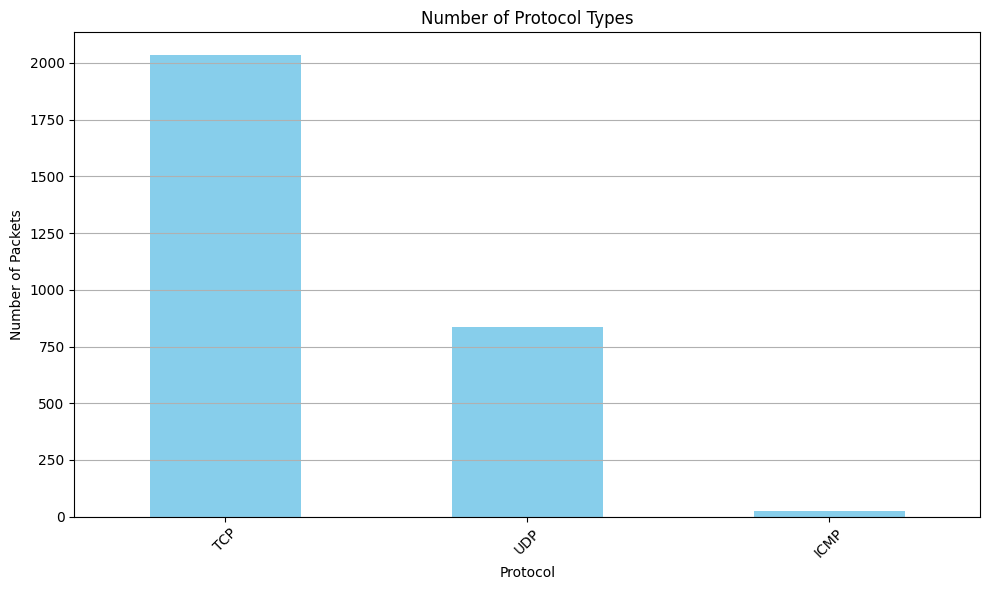

In [18]:
# Visualizing the number of packets of each protocol type

# Count the number of packets for each protocol
protocol_counts = df_cleaned['Protocol'].value_counts()

# Plot the number of protocol types
plt.figure(figsize=(10, 6))
protocol_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Protocol Types')
plt.xlabel('Protocol')
plt.ylabel('Number of Packets')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [3]:
# Extracting only the TCP packets
tcp_df = df_cleaned[df_cleaned['Protocol'] == 'TCP']
tcp_df = tcp_df.reset_index(drop=True)

tcp_df

,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,61.188.221.144,150.95.109.3,TCP,32165.0,8536.0,1704085200.52127,54
1,216.100.199.237,150.95.0.162,TCP,873.0,49948.0,1704085200.521271,66
2,150.95.110.196,61.29.232.80,TCP,56607.0,443.0,1704085200.521276,54
3,61.188.221.144,150.95.109.3,TCP,32165.0,8536.0,1704085200.521303,54
4,223.183.69.69,150.95.0.162,TCP,53829.0,443.0,1704085200.521305,54
...,...,...,...,...,...,...,...
2028,52.198.12.253,150.95.182.197,TCP,443.0,52306.0,1704085200.56163,54
2029,147.189.232.196,163.93.158.203,TCP,443.0,55880.0,1704085200.561634,66
2030,223.183.69.44,150.95.0.162,TCP,31334.0,443.0,1704085200.56164,54
2031,52.198.12.253,150.95.182.197,TCP,443.0,52306.0,1704085200.561659,54


In [19]:
# Finding the number of packets sent between each source and destination
packet_counts = tcp_df.groupby(
    ['Source IP', 'Destination IP']).size().reset_index(name='Packet Count')

# Sorting by descending order of source and desination packets
packet_counts_sorted = packet_counts.sort_values(
    by='Packet Count', ascending=False)

packet_counts_sorted

,Source IP,Destination IP,Packet Count
662,52.198.12.253,150.95.182.197,295
690,61.188.221.144,150.95.109.3,92
356,185.102.219.215,150.95.109.104,86
512,216.100.199.237,150.95.0.162,84
98,129.239.9.55,150.95.110.212,56
...,...,...,...
329,173.211.130.102,203.141.139.180,1
330,175.1.255.168,133.228.51.6,1
331,175.200.35.61,131.117.219.180,1
333,176.144.81.175,150.95.67.143,1


In [20]:
# Define the source and destination IP addresses you want to filter for
source_ip = '52.198.12.253'
destination_ip = '150.95.182.197'

# Filter DataFrame for rows with specific source and destination IP addresses
filtered_rows = tcp_df[(tcp_df['Source IP'] == source_ip) & (
    tcp_df['Destination IP'] == destination_ip)]

filtered_rows = filtered_rows.reset_index(drop=True)

filtered_rows

,Source IP,Destination IP,Protocol,Source Port,Destination Port,Timestamp,Packet Size
0,52.198.12.253,150.95.182.197,TCP,443.0,52308.0,1704085200.529721,54
1,52.198.12.253,150.95.182.197,TCP,443.0,52308.0,1704085200.529725,54
2,52.198.12.253,150.95.182.197,TCP,443.0,52308.0,1704085200.531709,54
3,52.198.12.253,150.95.182.197,TCP,443.0,52308.0,1704085200.531715,54
4,52.198.12.253,150.95.182.197,TCP,443.0,52308.0,1704085200.533999,54
...,...,...,...,...,...,...,...
290,52.198.12.253,150.95.182.197,TCP,443.0,52306.0,1704085200.561561,54
291,52.198.12.253,150.95.182.197,TCP,443.0,52306.0,1704085200.561566,54
292,52.198.12.253,150.95.182.197,TCP,443.0,52306.0,1704085200.56157,54
293,52.198.12.253,150.95.182.197,TCP,443.0,52306.0,1704085200.56163,54


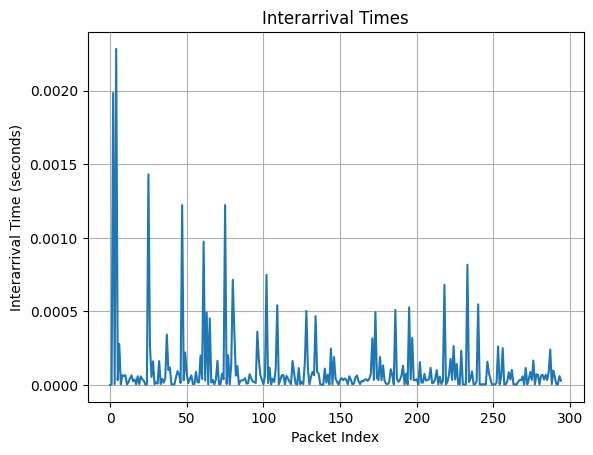

In [21]:
# Calculate packet interarrival time
filtered_rows['Interarrival Time'] = filtered_rows['Timestamp'].diff()

# Set the first interarrival time to be 0
filtered_rows.at[filtered_rows.index[0], 'Interarrival Time'] = 0

# Reset index
filtered_rows.reset_index(drop=True, inplace=True)

# Plot the interarrival times
plt.plot(filtered_rows['Interarrival Time'])
plt.title('Interarrival Times')
plt.xlabel('Packet Index')
plt.ylabel('Interarrival Time (seconds)')
plt.grid(True)
plt.show()

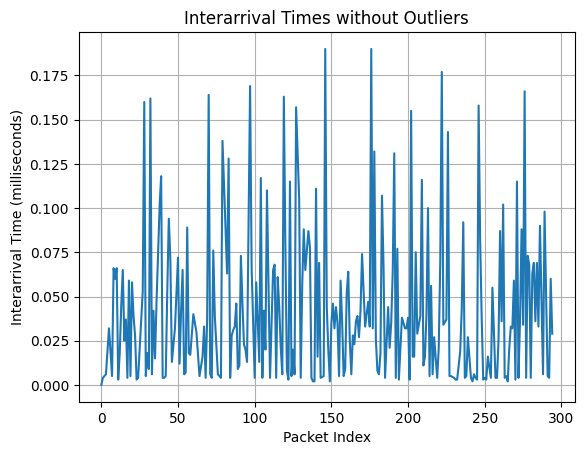

In [22]:
# Calculate interquartile range (IQR)
Q1 = filtered_rows['Interarrival Time'].quantile(0.25)
Q3 = filtered_rows['Interarrival Time'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
filtered_rows_no_outliers = filtered_rows[(filtered_rows['Interarrival Time'] >= lower_bound) & (
    filtered_rows['Interarrival Time'] <= upper_bound)]

# Plot the interarrival times without outliers
plt.plot(filtered_rows_no_outliers['Interarrival Time'] * 1000)
plt.title('Interarrival Times without Outliers')
plt.xlabel('Packet Index')
plt.ylabel('Interarrival Time (milliseconds)')
plt.grid(True)
plt.show()



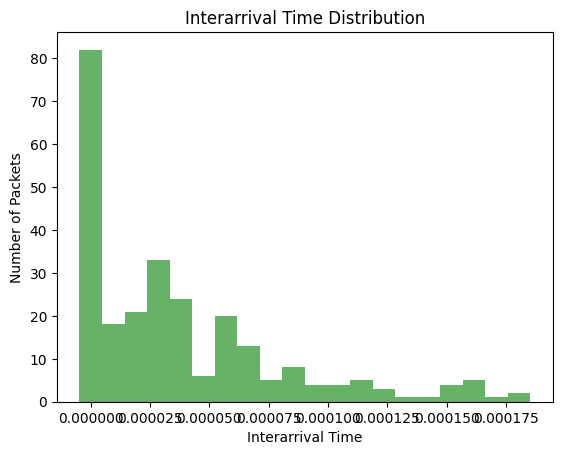

In [39]:
data = filtered_rows_no_outliers

# Calculate histogram data
hist, bins = np.histogram(np.array(data['Interarrival Time'], dtype=float), bins=20)

# Plot bar plot
plt.bar(bins[:-1], hist, width=np.diff(bins), alpha=0.6, color='g')

# Add labels and title
plt.xlabel('Interarrival Time')
plt.ylabel('Number of Packets')
plt.title('Interarrival Time Distribution')

# Show plot
plt.show()
